In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import missingno as msno

%matplotlib inline

In [2]:
# Reading in the data (using local path due to location of this notebook)

train_df_dum = pd.read_csv('../data/train_df_dum.csv', na_filter = False)
test_df_dum = pd.read_csv('../data/test_df_dum.csv',   na_filter = False)

#Source: Sam Stack and 
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

Checking that the NA values in the dataframes were not imported as null values:

In [3]:
train_df_dum.isnull().sum()[train_df_dum.isnull().sum() != 0].sort_values(ascending = False)

Series([], dtype: int64)

In [4]:
test_df_dum.isnull().sum()[test_df_dum.isnull().sum() != 0].sort_values(ascending = False)

Series([], dtype: int64)

### Feature Engineering 

#### Looking for outliers

Finding SalePrice outliers by finding values outside of threshold of 3 (using z-score):

In [5]:
threshold=3 #if datapoint outside of 3 standard deviations, it is an outlier   
mean_col = np.mean(train_df_dum['SalePrice'])
std_col =np.std(train_df_dum['SalePrice'])
outliers_list = []
for elem in train_df_dum['SalePrice']:
    z_score= (elem - mean_col) / std_col
    if np.abs(z_score) > threshold:
        outliers_list.append(elem)    
outliers_list.sort()
outliers_list;

#Source:
#Renu Khandelwal, https://medium.com/datadriveninvestor/finding-outliers-in-dataset-using-python-efc3fce6ce32

Finding SalePrice outliers by finding values outside of 1.5 * (Interquartile Range (IQR))

In [6]:
sorted(train_df_dum['SalePrice']);

In [7]:
q1, q3= np.percentile(train_df_dum['SalePrice'],[25,75])
print(q1, q3)

129800.0 214000.0


In [8]:
iqr = q3 - q1
iqr

84200.0

In [9]:
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 
print(lower_bound)
print(upper_bound)

#Source: https://medium.com/datadriveninvestor/finding-outliers-in-dataset-using-python-efc3fce6ce32

3500.0
340300.0


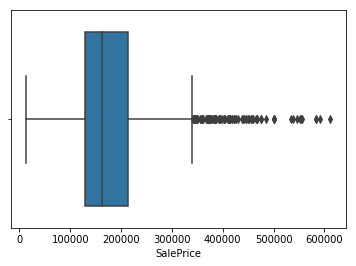

In [10]:
sns.boxplot(train_df_dum['SalePrice'])

Checking whether a log transform would remove most or all of the SalePrice outliers.  Unfortunately, not all of the outliers are removed in a log transformation; therefore, a PowerTransform might be appropriate.

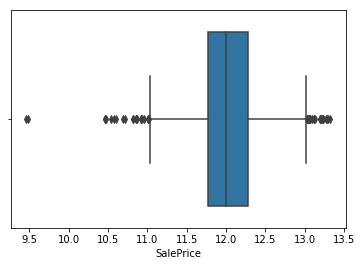

In [11]:
sns.boxplot(np.log1p(train_df_dum['SalePrice']))

Text(0.5, 1.0, 'Histogram of Sale Price Distribution')

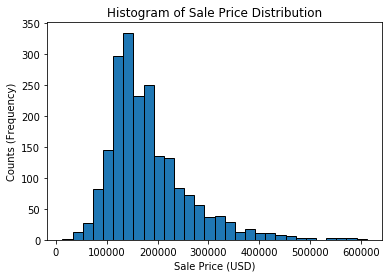

In [12]:
plt.hist(train_df_dum['SalePrice'], bins = 30, edgecolor = 'black');
plt.xlabel('Sale Price (USD)')
plt.ylabel('Counts (Frequency)')
plt.title('Histogram of Sale Price Distribution')

In [13]:
#Making sure can look at all columns when do df.head()
#pd.set_option("display.max_columns",81)
#train_df_dum.sort_values(by='SalePrice')['Yr Sold']
train_df_dum.sort_values(by='SalePrice')['SalePrice'];

The lower bound of the IQR is 3500.0 USD, and the upper bound of the IQR is 340,300 USD.
Properties with SalePrice < 15,000 USD will be removed because those prices are very low and may show affects from the 2008 housing crisis. 
Properties with SalePrices > 340,300 USD will be removed because those prices are very high and add right-skew to the SalePrice distribution. 

In [14]:
train_df_dum.shape

(2049, 315)

In [15]:
#Creating new df called train_no_OL (OL stands for outliers)
train_no_OL = train_df_dum[(train_df_dum['SalePrice'] > 15_000) & (train_df_dum['SalePrice'] < 500_000)]
train_no_OL.shape
#could go back to this if want, but scores not so good:
#train_no_OL = train_df_dum[(train_df_dum['SalePrice'] > 15_000) & (train_df_dum['SalePrice'] < 340_300)]

(2034, 315)

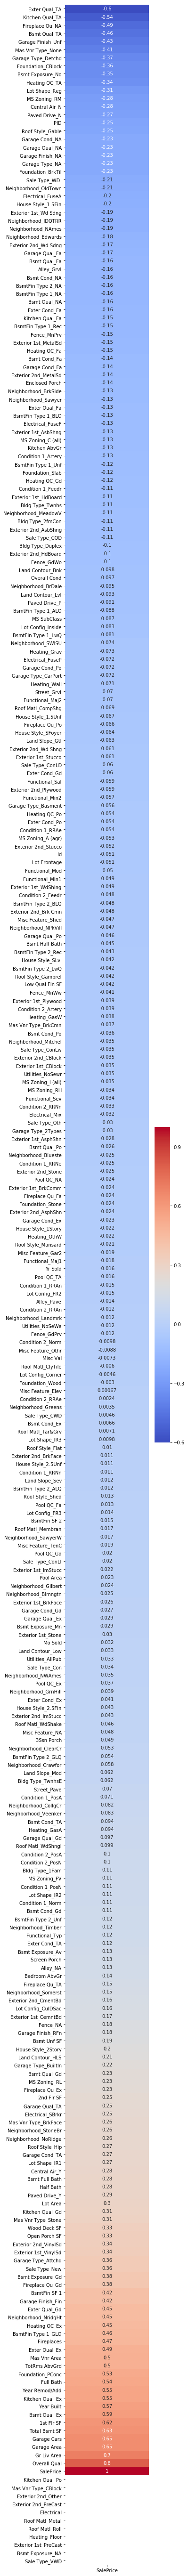

In [16]:
plt.figure(figsize = (4,100))
sns.heatmap(train_df_dum.corr()[['SalePrice']].sort_values('SalePrice'), annot=True, cmap='coolwarm')

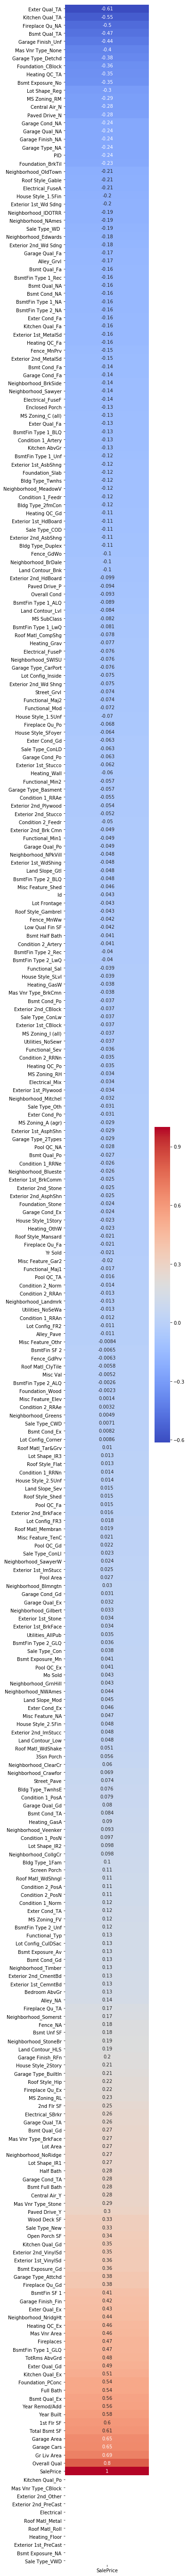

In [17]:
plt.figure(figsize = (4,100))
sns.heatmap(train_no_OL.corr()[['SalePrice']].sort_values('SalePrice'), annot=True, cmap='coolwarm');

In [18]:
abs(train_df_dum.corr()['SalePrice']['PID'])

0.2544762024810049

In [19]:
features_corr_over_pt4 = []
for col in train_df_dum.columns:
    if (abs(train_df_dum.corr()['SalePrice'][col]) >= 0.4) & (col != 'SalePrice'): 
        features_corr_over_pt4.append(col)

In [20]:
len(features_corr_over_pt4)

28

Note that several features have no correlation with SalePrice and are not on the heatmap above because they are dummy columns of 0's that were placed in the train set so the train set columns would match with the test set columns.  

In [21]:
#train_df_dum

In [22]:
#Looking at features that only have correlation with SalePrice magnitude > 0.5
feature_list = ['Exter Qual_TA', 'Kitchen Qual_TA', 'Mas Vnr Area', 'TotRms AbvGrd', 'Foundation_PConc', 
                'Full Bath', 'Year Remod/Add', 'Kitchen Qual_Ex', 'Year Built', 'Bsmt Qual_Ex', '1st Flr SF',
                'Total Bsmt SF', 'Garage Cars', 'Garage Area', 'Gr Liv Area', 'Overall Qual']

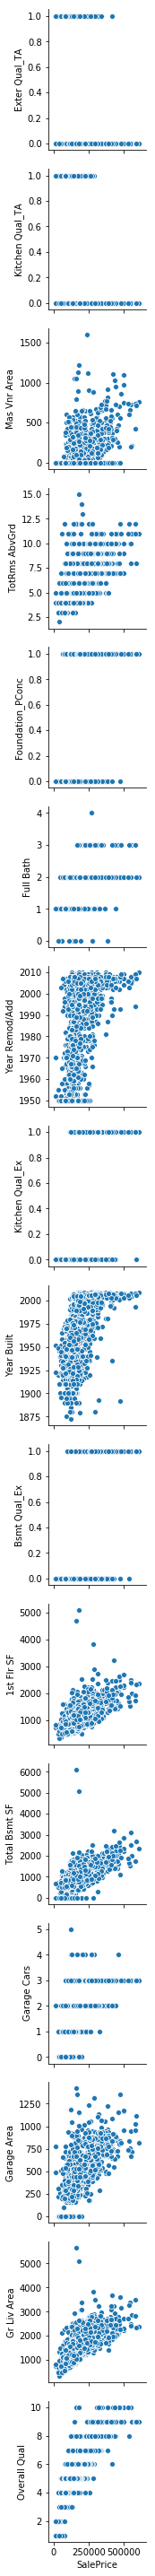

In [23]:
sns.pairplot(train_df_dum, x_vars = 'SalePrice', y_vars = feature_list)

In [24]:
X = train_df_dum[feature_list]
y = train_df_dum['SalePrice']

X_test_Kaggle = test_df_dum[feature_list]

In [25]:
X.shape

(2049, 16)

In [26]:
len(y)

2049

### Generating Model 5 (through iteration and choosing best model via R squared score)

#### Train-Test-Splitting Data:

In [27]:
#Using 70% of data for training and 30% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state=42)

#### Transforming Data

In [28]:
#Instantiating PowerTransformer for X variables:
pt = PowerTransformer()

pt.fit(X_train)
X_train_pt = pt.transform(X_train)
X_test_pt = pt.transform(X_test)

X_Kaggle_pt = pt.transform(X_test_Kaggle)

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [29]:
#Instantiating PowerTransformer for y variables:
pt_y = PowerTransformer()

# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
pt_y.fit(y_train.to_frame()) 
y_train_pt = pt_y.transform(y_train.to_frame())
y_test_pt = pt_y.transform(y_test.to_frame())

#### Modeling Data

In [30]:
#Instantiating Linear Regression Model
lr = LinearRegression()

#Fitting Linear Regression model:
lr.fit(X_train_pt, y_train_pt)

lr_preds = lr.predict(X_test_pt)
print(lr.coef_)
print(lr.intercept_)

lr_cv_scores = cross_val_score(lr, X_train_pt, y_train_pt, cv=5)
print(lr_cv_scores.mean())

lr_train_score = lr.score(X_train_pt, y_train_pt)
print(lr_train_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr_checking = pt_y.inverse_transform(lr_preds.reshape(-1,1))
lr_rev_test_score = r2_score(y_test, pred_reversed_lr_checking)
print(lr_rev_test_score)

lr_preds_Kaggle = lr.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr = pt_y.inverse_transform(lr_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[[ 0.0464155  -0.03546547  0.00147506 -0.03339862 -0.0236572  -0.05236652
   0.11562435  0.0495648   0.16689282  0.03520229  0.1016441   0.07931304
   0.08953458  0.02602855  0.35264198  0.30018745]]
[7.37704462e-16]
0.8305325582697918
0.8414010933001146
0.8859321715433303


The R squared scores were not as good as I hoped for this model, so the LassoCV, RidgeCV, and ElasticNet models will be evaluated, and they might be submitted to Kaggle.

In [31]:
#Instantiating LassoCV using 200 alphas to optimize over and 5 cross-validation folds:
lasso = LassoCV(n_alphas=200, cv=5)

#Fitting LassoCV model
lasso.fit(X_train_pt, y_train_pt[:, 0])

lasso_preds = lasso.predict(X_test_pt)
print(lasso.coef_)
print(lasso.intercept_)

lasso_cv_scores = cross_val_score(lasso, X_train_pt, y_train_pt[:, 0], cv=5)
print(lasso_cv_scores.mean())

lasso_train_score = lasso.score(X_train_pt, y_train_pt)
print(lasso_train_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso_checking = pt_y.inverse_transform(lasso_preds.reshape(-1,1))
lasso_rev_test_score = r2_score(y_test, pred_reversed_lasso_checking)
print(lasso_rev_test_score)

lasso_preds_Kaggle = lasso.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso = pt_y.inverse_transform(lasso_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[ 0.04133341 -0.03263696  0.00138627 -0.02745907 -0.01948113 -0.04901927
  0.11364252  0.04917185  0.16248753  0.03439476  0.10230742  0.0790681
  0.08748571  0.02766091  0.34453678  0.30069825]
7.215246958377053e-16
0.8290616979402328
0.8413631347434907
0.8856727688554639


In [32]:
#Instantiating RidgeCV using 200 alphas to optimize over and 5 cross-validation folds:
ridge = RidgeCV(alphas = np.linspace(0.01, 10, 100))

#Fitting the RidgeCV model:
ridge.fit(X_train_pt, y_train_pt)

ridge_preds = ridge.predict(X_test_pt)
print(ridge.coef_)
print(ridge.intercept_)

ridge_cv_scores = cross_val_score(ridge, X_train_pt, y_train_pt[:, 0], cv=5)
print(ridge_cv_scores.mean())

ridge_train_score = ridge.score(X_train_pt, y_train_pt)
print(ridge_train_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge_checking = pt_y.inverse_transform(ridge_preds.reshape(-1,1))
ridge_rev_test_score = r2_score(y_test, pred_reversed_ridge_checking)
print(ridge_rev_test_score)

ridge_preds_Kaggle = ridge.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge = pt_y.inverse_transform(ridge_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[[ 0.04346047 -0.03573409  0.00276914 -0.02686514 -0.02088927 -0.04849094
   0.11490111  0.04989682  0.16238396  0.03543643  0.10227091  0.08010493
   0.08714238  0.02994801  0.34166967  0.29754038]]
[7.16800659e-16]
0.8308422484646627
0.8413604588548697
0.8859330968946875


In [33]:
#Setting up array of potential l1 ratios for ElasticNetCV model 
enet_ratio = np.linspace(0.01, 1.0, 100)

#Instantiating ElasticNetCV model
enet_model = ElasticNetCV(n_alphas = 100, l1_ratio = enet_ratio, cv = 3)

# Fit model using optimal alpha
enet_model = enet_model.fit(X_train_pt, y_train_pt[:,0]) 

#Generating predictions
enet_model_preds = enet_model.predict(X_test_pt)
enet_model_preds_train = enet_model.predict(X_train_pt)

#Reverse transforming predictions:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_enet_checking = pt_y.inverse_transform(enet_model_preds.reshape(-1,1))

#Finding cross-validation score
enet_cv_scores = cross_val_score(enet_model, X_train_pt, y_train_pt[:,0], cv = 3)

#Evaluating model
print(enet_model.alpha_)
print(enet_model.l1_ratio_)
print(enet_cv_scores.mean())
print(r2_score(y_test_pt, enet_model_preds))
print(r2_score(y_train_pt, enet_model_preds_train))
print(r2_score(y_test, pred_reversed_enet_checking))

0.04097680456446354
0.02
0.8269213944339406
0.853191542073273
0.8402353719545881
0.884768216279228


### Trying to improve models by removing outliers

In [34]:
X = train_no_OL[feature_list]
y = train_no_OL['SalePrice']

X_test_Kaggle = test_df_dum[feature_list]

#### Train-Test-Splitting Data

In [35]:
#Using 70% of data for training and 30% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state=42)

#### Transforming Data

In [36]:
#Instantiating PowerTransformer for X variables:
pt = PowerTransformer()

pt.fit(X_train)
X_train_pt = pt.transform(X_train)
X_test_pt = pt.transform(X_test)

X_Kaggle_pt = pt.transform(X_test_Kaggle)

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2798: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [37]:
#Instantiating PowerTransformer for y variables:
pt_y = PowerTransformer()

# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
pt_y.fit(y_train.to_frame()) 
y_train_pt = pt_y.transform(y_train.to_frame())
y_test_pt = pt_y.transform(y_test.to_frame())

### Modeling Data

In [38]:
#Instantiating Linear Regression Model
lr = LinearRegression()

#Fitting Linear Regression model:
lr.fit(X_train_pt, y_train_pt)

lr_preds = lr.predict(X_test_pt)
print(lr.coef_)
print(lr.intercept_)

lr_cv_scores = cross_val_score(lr, X_train_pt, y_train_pt, cv=5)
print(lr_cv_scores.mean())

lr_train_score = lr.score(X_train_pt, y_train_pt)
print(lr_train_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr_checking = pt_y.inverse_transform(lr_preds.reshape(-1,1))
lr_rev_test_score = r2_score(y_test, pred_reversed_lr_checking)
print(lr_rev_test_score)

lr_preds_Kaggle = lr.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr = pt_y.inverse_transform(lr_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[[ 2.49039141e-02 -6.12705848e-02  1.25882023e-02  1.63909996e-01
  -1.01003793e-02  4.28074476e-02  1.16616139e-01  5.03565039e-02
   1.05071782e-01  4.24850394e-02 -6.24500451e-17  1.69674455e-01
   8.25046347e-02  1.22180216e-01  0.00000000e+00  3.27691625e-01]]
[-5.00514506e-16]
0.7981307542145303
0.8083520225141188
0.8286597612917999


In [39]:
#Instantiating LassoCV using 200 alphas to optimize over and 5 cross-validation folds:
lasso = LassoCV(n_alphas=200, cv=5)

#Fitting LassoCV model
lasso.fit(X_train_pt, y_train_pt[:, 0])

lasso_preds = lasso.predict(X_test_pt)
print(lasso.coef_)
print(lasso.intercept_)

lasso_cv_scores = cross_val_score(lasso, X_train_pt, y_train_pt[:, 0], cv=5)
print(lasso_cv_scores.mean())

lasso_train_score = lasso.score(X_train_pt, y_train_pt)
print(lasso_train_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso_checking = pt_y.inverse_transform(lasso_preds.reshape(-1,1))
lasso_rev_test_score = r2_score(y_test, pred_reversed_lasso_checking)
print(lasso_rev_test_score)

lasso_preds_Kaggle = lasso.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso = pt_y.inverse_transform(lasso_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[ 0.         -0.04794057  0.01060237  0.1602272   0.          0.03961333
  0.11155216  0.04799996  0.09298021  0.0386533   0.          0.16794343
  0.08267885  0.12045806  0.          0.3260638 ]
-4.896329881909641e-16
0.7977771098514305
0.8079289053926014
0.8294906658039365


In [40]:
#Instantiating RidgeCV using 200 alphas to optimize over and 5 cross-validation folds:
ridge = RidgeCV(alphas = np.linspace(0.01, 10, 100))

#Fitting the RidgeCV model:
ridge.fit(X_train_pt, y_train_pt)

ridge_preds = ridge.predict(X_test_pt)
print(ridge.coef_)
print(ridge.intercept_)

ridge_cv_scores = cross_val_score(ridge, X_train_pt, y_train_pt[:, 0], cv=5)
print(ridge_cv_scores.mean())

ridge_train_score = ridge.score(X_train_pt, y_train_pt)
print(ridge_train_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge_checking = pt_y.inverse_transform(ridge_preds.reshape(-1,1))
ridge_rev_test_score = r2_score(y_test, pred_reversed_ridge_checking)
print(ridge_rev_test_score)

ridge_preds_Kaggle = ridge.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge = pt_y.inverse_transform(ridge_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[[ 0.02246477 -0.06122975  0.01361973  0.16285855 -0.00855727  0.04379589
   0.11608564  0.05089438  0.10375804  0.04293293  0.          0.16947549
   0.08391438  0.12120913  0.          0.32301409]]
[-4.98560004e-16]
0.7983740968775622
0.8083388129266355
0.8284334326540093


In [41]:
#Setting up array of potential l1 ratios for ElasticNetCV model 
enet_ratio = np.linspace(0.01, 1.0, 100)

#Instantiating ElasticNetCV model
enet_model = ElasticNetCV(n_alphas = 100, l1_ratio = enet_ratio, cv = 3)

# Fit model using optimal alpha
enet_model = enet_model.fit(X_train_pt, y_train_pt[:,0]) 

#Generating predictions
enet_model_preds = enet_model.predict(X_test_pt)
enet_model_preds_train = enet_model.predict(X_train_pt)

#Reverse transforming predictions:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_enet_checking = pt_y.inverse_transform(enet_model_preds.reshape(-1,1))

#Finding cross-validation score
enet_cv_scores = cross_val_score(enet_model, X_train_pt, y_train_pt[:,0], cv = 3)

#Evaluating model
print(enet_model.alpha_)
print(enet_model.l1_ratio_)
print(enet_cv_scores.mean())
print(r2_score(y_test_pt, enet_model_preds))
print(r2_score(y_train_pt, enet_model_preds_train))
print(r2_score(y_test, pred_reversed_enet_checking))

0.043647692768685215
0.14
0.8000368506599448
0.8201168791348966
0.807655564220241
0.8276471034930678


### Creating model using more features (features with magnitude of correlation to SalePrice > 0.4

In [42]:
X = train_df_dum[features_corr_over_pt4]
y = train_df_dum['SalePrice']

X_test_Kaggle = test_df_dum[features_corr_over_pt4]

In [43]:
X.shape

(2049, 28)

In [44]:
y.shape

(2049,)

In [45]:
X_test_Kaggle.shape

(879, 28)

### Train-Test-Splitting data

In [46]:
#Using 70% of data for training and 30% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state=42)

### Transforming data

In [47]:
#Instantiating PowerTransformer for X variables:
pt = PowerTransformer()

pt.fit(X_train)
X_train_pt = pt.transform(X_train)
X_test_pt = pt.transform(X_test)

X_Kaggle_pt = pt.transform(X_test_Kaggle)

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [48]:
#Instantiating PowerTransformer for y variables:
pt_y = PowerTransformer()

# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
pt_y.fit(y_train.to_frame()) 
y_train_pt = pt_y.transform(y_train.to_frame())
y_test_pt = pt_y.transform(y_test.to_frame())

### Modeling Data

In [49]:
#Instantiating Linear Regression Model
lr = LinearRegression()

#Fitting Linear Regression model:
lr.fit(X_train_pt, y_train_pt)

lr_preds = lr.predict(X_test_pt)
print(lr.coef_)
print(lr.intercept_)

lr_cv_scores = cross_val_score(lr, X_train_pt, y_train_pt, cv=5)
print(lr_cv_scores.mean())

lr_train_score = lr.score(X_train_pt, y_train_pt)
print(lr_train_score)

lr_test_score = lr.score(X_test_pt, y_test_pt)
print(lr_test_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr_checking = pt_y.inverse_transform(lr_preds.reshape(-1,1))
lr_rev_test_score = r2_score(y_test, pred_reversed_lr_checking)
print(lr_rev_test_score)

lr_preds_Kaggle = lr.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr = pt_y.inverse_transform(lr_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[[ 0.26765044  0.12280392  0.10031023 -0.04792022  0.14061691  0.02208248
   0.09914576  0.28842302 -0.0150657   0.00349134  0.14240822  0.09204464
   0.0081609   0.02766886 -0.02395004  0.11936682  0.26704852  0.26457051
  -0.00604646  0.01818159  0.01831464 -0.01571861  0.04461584  0.04067752
  -0.02941388  0.05953679  0.01024406 -0.00562192]]
[7.26808151e-16]
0.8553722956995227
0.8681210795397396
0.8716940106611828
0.8980158400057268


In [50]:
#Instantiating LassoCV using 200 alphas to optimize over and 5 cross-validation folds:
lasso = LassoCV(n_alphas=200, cv=5)

#Fitting LassoCV model
lasso.fit(X_train_pt, y_train_pt[:, 0])

lasso_preds = lasso.predict(X_test_pt)
print(lasso.coef_)
print(lasso.intercept_)

lasso_cv_scores = cross_val_score(lasso, X_train_pt, y_train_pt[:, 0], cv=5)
print(lasso_cv_scores.mean())

lasso_train_score = lasso.score(X_train_pt, y_train_pt)
print(lasso_train_score)

lasso_test_score = lasso.score(X_test_pt, y_test_pt)
print(lasso_test_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso_checking = pt_y.inverse_transform(lasso_preds.reshape(-1,1))
lasso_rev_test_score = r2_score(y_test, pred_reversed_lasso_checking)
print(lasso_rev_test_score)

lasso_preds_Kaggle = lasso.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso = pt_y.inverse_transform(lasso_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[ 0.27206873  0.11520391  0.10139624 -0.01779332  0.13871888  0.02460884
  0.0998021   0.28458807 -0.00964571  0.00231568  0.08484377  0.08694738
  0.01239922  0.0238734   0.          0.08440216  0.18507099  0.18417616
 -0.          0.0168266   0.01452906 -0.01112247  0.04427398  0.04070644
 -0.02459499  0.          0.00961458 -0.00115241]
7.154110711716599e-16
0.8566209703187055
0.867536154211364
0.8724833423334092
0.8977755717384917


In [51]:
#Instantiating RidgeCV using 200 alphas to optimize over and 5 cross-validation folds:
ridge = RidgeCV(alphas = np.linspace(0.01, 10, 100))

#Fitting the RidgeCV model:
ridge.fit(X_train_pt, y_train_pt)

ridge_preds = ridge.predict(X_test_pt)
print(ridge.coef_)
print(ridge.intercept_)

ridge_cv_scores = cross_val_score(ridge, X_train_pt, y_train_pt[:, 0], cv=5)
print(ridge_cv_scores.mean())

ridge_train_score = ridge.score(X_train_pt, y_train_pt)
print(ridge_train_score)

ridge_test_score = ridge.score(X_test_pt, y_test_pt)
print(ridge_test_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge_checking = pt_y.inverse_transform(ridge_preds.reshape(-1,1))
ridge_rev_test_score = r2_score(y_test, pred_reversed_ridge_checking)
print(ridge_rev_test_score)

ridge_preds_Kaggle = ridge.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge = pt_y.inverse_transform(ridge_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[[ 0.26839873  0.12046549  0.10179766 -0.03083823  0.13956743  0.02502154
   0.09916103  0.27966713 -0.01290046  0.00846837  0.11678151  0.08756211
   0.01452428  0.02621222 -0.00854411  0.09391375  0.20877786  0.20777836
  -0.00457407  0.01800615  0.01709497 -0.01415366  0.04550444  0.04119094
  -0.02860153  0.03195431  0.01071137 -0.0046436 ]]
[6.99399753e-16]
0.8560999982363443
0.867886236913699
0.8726704996961493
0.8982898892302849


In [52]:
#Setting up array of potential l1 ratios for ElasticNetCV model 
enet_ratio = np.linspace(0.01, 1.0, 100)

#Instantiating ElasticNetCV model
enet_model = ElasticNetCV(n_alphas = 100, l1_ratio = enet_ratio, cv = 3)

# Fit model using optimal alpha
enet_model = enet_model.fit(X_train_pt, y_train_pt[:,0]) 

#Generating predictions
enet_model_preds = enet_model.predict(X_test_pt)
enet_model_preds_train = enet_model.predict(X_train_pt)

#Reverse transforming predictions:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_enet_checking = pt_y.inverse_transform(enet_model_preds.reshape(-1,1))

#Finding cross-validation score
enet_cv_scores = cross_val_score(enet_model, X_train_pt, y_train_pt[:,0], cv = 3)

#Evaluating model
print(enet_model.alpha_)
print(enet_model.l1_ratio_)
print(enet_cv_scores.mean())
print(r2_score(y_test_pt, enet_model_preds))
print(r2_score(y_train_pt, enet_model_preds_train))
print(r2_score(y_test, pred_reversed_enet_checking))

0.00233406818346952
1.0
0.8539563013555024
0.8726284297932558
0.8672608624829163
0.8977085955341192


In [53]:
scores = pd.DataFrame()

scores['R Squared Scores'] = ['CrossVal', 'Train_R2', 'Test_R2', 'Test_Rev_R2']
scores['LR_Feats_Corr_AbvPt4']      = [lr_cv_scores.mean(), lr_train_score, lr_test_score, lr_rev_test_score]
scores['LassoCV_Feats_Corr_AbvPt4'] = [lasso_cv_scores.mean(), lasso_train_score, lasso_test_score, lasso_rev_test_score]
scores['RidgeCV_Feats_Corr_AbvPt4'] = [ridge_cv_scores.mean(), ridge_train_score, ridge_test_score, ridge_rev_test_score]
scores['ElasticNet_Feats_Corr_AbvPt4'] = [enet_cv_scores.mean(), r2_score(y_train_pt, enet_model_preds_train),
                                 r2_score(y_test_pt, enet_model_preds), 
                                 r2_score(y_test, pred_reversed_enet_checking)]

scores


,R Squared Scores,LR_Feats_Corr_AbvPt4,LassoCV_Feats_Corr_AbvPt4,RidgeCV_Feats_Corr_AbvPt4,ElasticNet_Feats_Corr_AbvPt4
0,CrossVal,0.855372,0.856621,0.856100,0.853956
1,Train_R2,0.868121,0.867536,0.867886,0.867261
2,Test_R2,0.871694,0.872483,0.872670,0.872628
3,Test_Rev_R2,0.898016,0.897776,0.898290,0.897709


The R sq scores are similar to each other, but the model using RidgeCV seems to have good R squared scores across the board, so it will be submitted to Kaggle.

In [54]:
ridge_preds_Kaggle = ridge.predict(X_Kaggle_pt)

In [55]:
#enet_preds_Kaggle

In [56]:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge_Kaggle = pt_y.inverse_transform(ridge_preds_Kaggle.reshape(-1,1))

In [57]:
#pred_reversed_ridge_Kaggle

In [58]:
#test_df_dum

In [59]:
#When remembered to reverse-transform the prediction values:
submission = test_df_dum[['Id']]
submission['SalePrice'] = pred_reversed_ridge_Kaggle

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
submission.head()

,Id,SalePrice
0,2658,132602.830224
1,2718,164264.600504
2,2414,206927.382083
3,1989,113942.056263
4,625,171947.778126


In [61]:
#submission.describe()
submission.shape

(879, 2)

In [62]:
submission.to_csv('../data/submissions/submission_ridge_InvTrans_model_5.csv', index = False)

Score got on Kaggle: 36211.62335

### Generating Model 6 (removing outliers to see if there is a difference)

In [63]:
X = train_no_OL[features_corr_over_pt4]
y = train_no_OL['SalePrice']

X_test_Kaggle = test_df_dum[features_corr_over_pt4]

#### Train-Test-Splitting Data

In [64]:
#Using 70% of data for training and 30% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state=42)

#### Transforming Data

In [65]:
#Instantiating PowerTransformer for X variables:
pt = PowerTransformer()

pt.fit(X_train)
X_train_pt = pt.transform(X_train)
X_test_pt = pt.transform(X_test)

X_Kaggle_pt = pt.transform(X_test_Kaggle)

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2798: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [66]:
#Instantiating PowerTransformer for y variables:
pt_y = PowerTransformer()

# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
pt_y.fit(y_train.to_frame()) 
y_train_pt = pt_y.transform(y_train.to_frame())
y_test_pt = pt_y.transform(y_test.to_frame())

#### Modeling Data

In [67]:
#Instantiating Linear Regression Model
lr = LinearRegression()

#Fitting Linear Regression model:
lr.fit(X_train_pt, y_train_pt)

lr_preds = lr.predict(X_test_pt)
print(lr.coef_)
print(lr.intercept_)

lr_cv_scores = cross_val_score(lr, X_train_pt, y_train_pt, cv=5)
print(lr_cv_scores.mean())

lr_train_score = lr.score(X_train_pt, y_train_pt)
print(lr_train_score)

lr_test_score = lr.score(X_test_pt, y_test_pt)
print(lr_test_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr_checking = pt_y.inverse_transform(lr_preds.reshape(-1,1))
lr_rev_test_score = r2_score(y_test, pred_reversed_lr_checking)
print(lr_rev_test_score)

lr_preds_Kaggle = lr.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr = pt_y.inverse_transform(lr_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[[ 2.82772913e-01  4.83863515e-02  1.16579169e-01  1.37352703e-02
   1.55187333e-01  1.02003367e-01 -2.22044605e-16  2.77555756e-16
   5.86781522e-02  1.53027642e-01  2.32929531e-01  7.06904096e-02
   1.01732351e-01  1.12363079e-02  3.36782513e-02  5.45331138e-02
   1.98084185e-01  1.84467529e-01  2.69830083e-03  2.95722671e-02
  -3.33971523e-02 -1.94835119e-02  3.50358732e-02  5.52437894e-02
  -4.75642279e-02  9.48988228e-02 -4.48118826e-03 -3.24381005e-02]]
[-4.606305e-16]
0.8371418416311759
0.8506637680873572
0.8526264008191098
0.8605679800199878


In [68]:
#Instantiating LassoCV using 200 alphas to optimize over and 5 cross-validation folds:
lasso = LassoCV(n_alphas=200, cv=5)

#Fitting LassoCV model
lasso.fit(X_train_pt, y_train_pt[:, 0])

lasso_preds = lasso.predict(X_test_pt)
print(lasso.coef_)
print(lasso.intercept_)

lasso_cv_scores = cross_val_score(lasso, X_train_pt, y_train_pt[:, 0], cv=5)
print(lasso_cv_scores.mean())

lasso_train_score = lasso.score(X_train_pt, y_train_pt)
print(lasso_train_score)

lasso_test_score = lasso.score(X_test_pt, y_test_pt)
print(lasso_test_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso_checking = pt_y.inverse_transform(lasso_preds.reshape(-1,1))
lasso_rev_test_score = r2_score(y_test, pred_reversed_lasso_checking)
print(lasso_rev_test_score)

lasso_preds_Kaggle = lasso.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso = pt_y.inverse_transform(lasso_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[ 0.28394543  0.04759298  0.1176045  -0.          0.15317488  0.10416973
  0.          0.          0.05729243  0.1533      0.17313355  0.0682225
  0.10372873  0.00899989  0.01702464  0.03172274  0.14052024  0.12699415
  0.00072369  0.02881242 -0.03362459 -0.01440221  0.03498826  0.05467903
 -0.04606962  0.03320195 -0.00164697 -0.0280974 ]
-4.807570653895066e-16
0.836727543788555
0.850315251709141
0.8523807261580548
0.8589294204948446


In [69]:
#Instantiating RidgeCV using 200 alphas to optimize over and 5 cross-validation folds:
ridge = RidgeCV(alphas = np.linspace(0.01, 10, 100))

#Fitting the RidgeCV model:
ridge.fit(X_train_pt, y_train_pt)

ridge_preds = ridge.predict(X_test_pt)
print(ridge.coef_)
print(ridge.intercept_)

ridge_cv_scores = cross_val_score(ridge, X_train_pt, y_train_pt[:, 0], cv=5)
print(ridge_cv_scores.mean())

ridge_train_score = ridge.score(X_train_pt, y_train_pt)
print(ridge_train_score)

ridge_test_score = ridge.score(X_test_pt, y_test_pt)
print(ridge_test_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge_checking = pt_y.inverse_transform(ridge_preds.reshape(-1,1))
ridge_rev_test_score = r2_score(y_test, pred_reversed_ridge_checking)
print(ridge_rev_test_score)

ridge_preds_Kaggle = ridge.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge = pt_y.inverse_transform(ridge_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[[ 0.27999464  0.04894122  0.11649998  0.00553425  0.15441311  0.10395331
   0.          0.          0.05835304  0.1527282   0.19128697  0.07077028
   0.10244996  0.01011832  0.02448198  0.03856611  0.15564115  0.1428458
   0.0026829   0.02992821 -0.03402215 -0.01790661  0.03568225  0.05532521
  -0.04785784  0.05201898 -0.00429547 -0.0308744 ]]
[-4.72201338e-16]
0.8380291640527517
0.8504929218878912
0.852333564710533
0.8594959701558278


In [70]:
#Setting up array of potential l1 ratios for ElasticNetCV model 
enet_ratio = np.linspace(0.01, 1.0, 100)

#Instantiating ElasticNetCV model
enet_model = ElasticNetCV(n_alphas = 100, l1_ratio = enet_ratio, cv = 3)

# Fit model using optimal alpha
enet_model = enet_model.fit(X_train_pt, y_train_pt[:,0]) 

#Generating predictions
enet_model_preds = enet_model.predict(X_test_pt)
enet_model_preds_train = enet_model.predict(X_train_pt)

#Reverse transforming predictions:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_enet_checking = pt_y.inverse_transform(enet_model_preds.reshape(-1,1))

#Finding cross-validation score
enet_cv_scores = cross_val_score(enet_model, X_train_pt, y_train_pt[:,0], cv = 3)

#Evaluating model
print(enet_model.alpha_)
print(enet_model.l1_ratio_)
print(enet_cv_scores.mean())
print(r2_score(y_test_pt, enet_model_preds))
print(r2_score(y_train_pt, enet_model_preds_train))
print(r2_score(y_test, pred_reversed_enet_checking))

0.026926517849713116
0.03
0.8381556093765115
0.85147333572651
0.8494623138200638
0.8575591282535038


In [71]:
scores = pd.DataFrame()

scores['R Squared Scores'] = ['CrossVal', 'Train_R2', 'Test_R2', 'Test_Rev_R2']
scores['LR_Feats_Corr_AbvPt4']      = [lr_cv_scores.mean(), lr_train_score, lr_test_score, lr_rev_test_score]
scores['LassoCV_Feats_Corr_AbvPt4'] = [lasso_cv_scores.mean(), lasso_train_score, lasso_test_score, lasso_rev_test_score]
scores['RidgeCV_Feats_Corr_AbvPt4'] = [ridge_cv_scores.mean(), ridge_train_score, ridge_test_score, ridge_rev_test_score]
scores['ElasticNet_Feats_Corr_AbvPt4'] = [enet_cv_scores.mean(), r2_score(y_train_pt, enet_model_preds_train),
                                 r2_score(y_test_pt, enet_model_preds), 
                                 r2_score(y_test, pred_reversed_enet_checking)]

scores

,R Squared Scores,LR_Feats_Corr_AbvPt4,LassoCV_Feats_Corr_AbvPt4,RidgeCV_Feats_Corr_AbvPt4,ElasticNet_Feats_Corr_AbvPt4
0,CrossVal,0.837142,0.836728,0.838029,0.838156
1,Train_R2,0.850664,0.850315,0.850493,0.849462
2,Test_R2,0.852626,0.852381,0.852334,0.851473
3,Test_Rev_R2,0.860568,0.858929,0.859496,0.857559


The R sq scores are worse when using data with outliers removed.  Perhaps this is because each datapoint is important, and PowerTransform normalizes data well enough to reduce affects of outliers to the point that they do not need to be removed manually for this dataset.  Therefore these models with lower R squared scores will not be submitted to Kaggle.

### Adding interaction terms to improve the model

#### Looking at bathroom terms and summing them up

In [72]:
train_df_dum['Bsmt Full Bath'].value_counts() #Full bathrooms in basement

0.0    1201
1.0     823
2.0      23
3.0       2
Name: Bsmt Full Bath, dtype: int64

In [73]:
train_df_dum['Bsmt Half Bath'].value_counts() #Half bathrooms in basement

0.0    1923
1.0     122
2.0       4
Name: Bsmt Half Bath, dtype: int64

In [74]:
train_df_dum['Full Bath'].value_counts() #Full bathrooms above grade (above ground (not in basement))

2    1094
1     900
3      45
0       8
4       2
Name: Full Bath, dtype: int64

In [75]:
train_df_dum['Half Bath'].value_counts() #Half baths above grade (above ground (not in basement))    

0    1306
1     725
2      18
Name: Half Bath, dtype: int64

In [76]:
#Finding total number of bathrooms in each column (multipling half bathrooms by 0.5)
train_df_dum['Total Baths'] = (train_df_dum['Bsmt Full Bath'] + (0.5 * train_df_dum['Bsmt Half Bath']) + 
                               train_df_dum['Full Bath'] + (0.5 * train_df_dum['Half Bath']))

In [77]:
train_df_dum['Total Baths'].corr(train_df_dum['SalePrice'])

#Source: https://stackoverflow.com/questions/42579908/use-corr-to-get-the-correlation-between-two-columns

0.6299809978063579

In [78]:
train_df_dum['Full Bath'].corr(train_df_dum['SalePrice'])

0.5380226436502277

The correlation of Total Baths to SalePrice has a magnitude of approx. 0.61, and it is greater than 0.4 (and it is greater than the correlation of Full Bath to SalePrice), so it will be added to the features list.  The Full Bath column name will be removed to avoid creating collinearity.

In [79]:
features_corr_over_pt4_intns = []
for col in features_corr_over_pt4:
    if col != 'Full Bath' and col != 'Yrs Since Remod' and col != 'Yrs Since Built' and col != 'BsmtFin SF 1+2':
        features_corr_over_pt4_intns.append(col)

In [80]:
len(features_corr_over_pt4_intns)

27

In [81]:
features_corr_over_pt4_intns

['Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'Total Bsmt SF',
 '1st Flr SF',
 'Gr Liv Area',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Cars',
 'Garage Area',
 'Neighborhood_NridgHt',
 'Mas Vnr Type_None',
 'Exter Qual_Ex',
 'Exter Qual_Gd',
 'Exter Qual_TA',
 'Foundation_PConc',
 'Bsmt Qual_Ex',
 'Bsmt Qual_TA',
 'BsmtFin Type 1_GLQ',
 'Heating QC_Ex',
 'Kitchen Qual_Ex',
 'Kitchen Qual_TA',
 'Fireplace Qu_NA',
 'Garage Finish_Fin',
 'Garage Finish_Unf']

In [82]:
features_corr_over_pt4_intns.append('Total Baths')

In [83]:
len(features_corr_over_pt4_intns)

28

In [84]:
#features_corr_over_pt4_intns

Adding this new feature-interaction feature (Total Baths) to the test set:

In [85]:
#Finding total number of bathrooms in each column (multipling half bathrooms by 0.5)
test_df_dum['Total Baths'] = (test_df_dum['Bsmt Full Bath'] + (0.5 * test_df_dum['Bsmt Half Bath']) + 
                              test_df_dum['Full Bath'] + (0.5 * test_df_dum['Half Bath']))

#### Looking at year bought minus year renovated (or added to) and year bought minus year built

In [86]:
train_df_dum['Yrs Since Remod'] = train_df_dum['Yr Sold'] - train_df_dum['Year Remod/Add']
test_df_dum['Yrs Since Remod'] = test_df_dum['Yr Sold'] - test_df_dum['Year Remod/Add']

In [87]:
train_df_dum['Yrs Since Remod'].corr(train_df_dum['SalePrice'])

-0.5517215534142306

In [88]:
train_df_dum['Yr Sold'].corr(train_df_dum['SalePrice'])

-0.015915152122041053

In [89]:
train_df_dum['Year Remod/Add'].corr(train_df_dum['SalePrice'])

0.5503378448365674

The magnitude of correlation between the Yrs Since Remod and SalePrice is very close to the Year Remod/Add and SalePrice correlation, so this Yrs Since Remod interaction term will not be used in this model.

In [90]:
train_df_dum['Yrs Since Built'] = train_df_dum['Yr Sold'] - train_df_dum['Year Built']
test_df_dum['Yrs Since Built'] = test_df_dum['Yr Sold'] - test_df_dum['Year Built']

In [91]:
train_df_dum['Yrs Since Built'].corr(train_df_dum['SalePrice'])

-0.5716982587091818

In [92]:
train_df_dum['Yr Sold'].corr(train_df_dum['SalePrice'])

-0.015915152122041053

In [93]:
train_df_dum['Year Built'].corr(train_df_dum['SalePrice'])

0.5716584615619015

The magnitude of correlation between the Yrs Since Built and SalePrice is very close to the Year Built and SalePrice correlation, so this Yrs Since Built interaction term will not be used in this model.

In [94]:
#### Adding BsmtFin SF 1 and BsmtFin SF 2 values together

In [95]:
features_corr_over_pt4_intns;

In [96]:
train_df_dum['BsmtFin SF 1+2'] = train_df_dum['BsmtFin SF 1'] + train_df_dum['BsmtFin SF 2']
test_df_dum['BsmtFin SF 1+2'] = test_df_dum['BsmtFin SF 1'] - test_df_dum['BsmtFin SF 2']

In [97]:
train_df_dum['BsmtFin SF 1+2'].corr(train_df_dum['SalePrice'])

0.41049716754666354

In [98]:
train_df_dum['BsmtFin SF 1'].corr(train_df_dum['SalePrice'])

0.423385261132744

In [99]:
train_df_dum['BsmtFin SF 2'].corr(train_df_dum['SalePrice'])

0.01475906282848876

The magnitude of correlation between the BsmtFin SF 1+2 and SalePrice is lower than the BsmtFin SF 1 and SalePrice correlation, so this BsmtFin SF 1+2 interaction term will not be used in this model.

In [100]:
### Remember to add data dictionary for the one interaction feature created!!!

#### Creating models including the total bathrooms interaction term

In [101]:
X = train_df_dum[features_corr_over_pt4_intns]
y = train_df_dum['SalePrice']

X_test_Kaggle = test_df_dum[features_corr_over_pt4_intns]

#### Train-Test_Splitting Data

In [102]:
#Using 70% of data for training and 30% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state=42)

#### Transforming Data

In [103]:
#Instantiating PowerTransformer for X variables:
pt = PowerTransformer()

pt.fit(X_train)
X_train_pt = pt.transform(X_train)
X_test_pt = pt.transform(X_test)

X_Kaggle_pt = pt.transform(X_test_Kaggle)

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [104]:
#Instantiating PowerTransformer for y variables:
pt_y = PowerTransformer()

# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
pt_y.fit(y_train.to_frame()) 
y_train_pt = pt_y.transform(y_train.to_frame())
y_test_pt = pt_y.transform(y_test.to_frame())

#### Modeling

In [105]:
#Instantiating Linear Regression Model
lr = LinearRegression()

#Fitting Linear Regression model:
lr.fit(X_train_pt, y_train_pt)

lr_preds = lr.predict(X_test_pt)
print(lr.coef_)
print(lr.intercept_)

lr_cv_scores = cross_val_score(lr, X_train_pt, y_train_pt, cv=5)
print(lr_cv_scores.mean())

lr_train_score = lr.score(X_train_pt, y_train_pt)
print(lr_train_score)

lr_test_score = lr.score(X_test_pt, y_test_pt)
print(lr_test_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr_checking = pt_y.inverse_transform(lr_preds.reshape(-1,1))
lr_rev_test_score = r2_score(y_test, pred_reversed_lr_checking)
print(lr_rev_test_score)

lr_preds_Kaggle = lr.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr = pt_y.inverse_transform(lr_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[[ 0.26950112  0.1104509   0.09559237 -0.0460449   0.13292632  0.0210546
   0.10113337  0.26594142  0.00222916  0.14336411  0.08468175  0.0144032
   0.02837005 -0.02316306  0.1182927   0.26567249  0.26325827 -0.00482767
   0.0197296   0.02223194 -0.01902794  0.04703591  0.04156615 -0.02885358
   0.05930889  0.01204969 -0.00199974  0.03130955]]
[7.13358726e-16]
0.8558938081212275
0.8683644465717473
0.87155699500131
0.8976795735693629


In [106]:
#Instantiating LassoCV using 200 alphas to optimize over and 5 cross-validation folds:
lasso = LassoCV(n_alphas=200, cv=5)

#Fitting LassoCV model
lasso.fit(X_train_pt, y_train_pt[:, 0])

lasso_preds = lasso.predict(X_test_pt)
print(lasso.coef_)
print(lasso.intercept_)

lasso_cv_scores = cross_val_score(lasso, X_train_pt, y_train_pt[:, 0], cv=5)
print(lasso_cv_scores.mean())

lasso_train_score = lasso.score(X_train_pt, y_train_pt)
print(lasso_train_score)

lasso_test_score = lasso.score(X_test_pt, y_test_pt)
print(lasso_test_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso_checking = pt_y.inverse_transform(lasso_preds.reshape(-1,1))
lasso_rev_test_score = r2_score(y_test, pred_reversed_lasso_checking)
print(lasso_rev_test_score)

lasso_preds_Kaggle = lasso.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso = pt_y.inverse_transform(lasso_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[ 0.27380168  0.10390002  0.09710447 -0.01713648  0.13017619  0.02367759
  0.10157863  0.26444374  0.00143776  0.08551562  0.08060799  0.01839581
  0.0246508   0.          0.08359983  0.18403993  0.18339644 -0.
  0.0180466   0.01792621 -0.01407912  0.04674586  0.04148467 -0.02411658
  0.          0.01056007 -0.          0.03183481]
7.014004244472735e-16
0.8570363153400887
0.8678098471172208
0.8724360545115353
0.8976310732262585


In [107]:
#Instantiating RidgeCV using 200 alphas to optimize over and 5 cross-validation folds:
ridge = RidgeCV(alphas = np.linspace(0.01, 10, 100))

#Fitting the RidgeCV model:
ridge.fit(X_train_pt, y_train_pt)

ridge_preds = ridge.predict(X_test_pt)
print(ridge.coef_)
print(ridge.intercept_)

ridge_cv_scores = cross_val_score(ridge, X_train_pt, y_train_pt[:, 0], cv=5)
print(ridge_cv_scores.mean())

ridge_train_score = ridge.score(X_train_pt, y_train_pt)
print(ridge_train_score)

ridge_test_score = ridge.score(X_test_pt, y_test_pt)
print(ridge_test_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge_checking = pt_y.inverse_transform(ridge_preds.reshape(-1,1))
ridge_rev_test_score = r2_score(y_test, pred_reversed_ridge_checking)
print(ridge_rev_test_score)

ridge_preds_Kaggle = ridge.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge = pt_y.inverse_transform(ridge_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[[ 0.27011553  0.10807069  0.09687492 -0.030096    0.13066793  0.02397801
   0.10127427  0.25723446  0.00686528  0.11682006  0.08042733  0.02040505
   0.02706383 -0.00884585  0.09300568  0.20750755  0.20654139 -0.00346532
   0.01947015  0.02115561 -0.01774303  0.04803943  0.04208453 -0.02795551
   0.03103451  0.01246308 -0.0007719   0.03509014]]
[6.85313921e-16]
0.8566076156483691
0.8681326811986055
0.8724281473516292
0.8979050972149721


In [108]:
#Setting up array of potential l1 ratios for ElasticNetCV model 
enet_ratio = np.linspace(0.01, 1.0, 100)

#Instantiating ElasticNetCV model
enet_model = ElasticNetCV(n_alphas = 100, l1_ratio = enet_ratio, cv = 3)

# Fit model using optimal alpha
enet_model = enet_model.fit(X_train_pt, y_train_pt[:,0]) 

#Generating predictions
enet_model_preds = enet_model.predict(X_test_pt)
enet_model_preds_train = enet_model.predict(X_train_pt)

#Reverse transforming predictions:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_enet_checking = pt_y.inverse_transform(enet_model_preds.reshape(-1,1))

#Finding cross-validation score
enet_cv_scores = cross_val_score(enet_model, X_train_pt, y_train_pt[:,0], cv = 3)

#Evaluating model
print(enet_model.alpha_)
print(enet_model.l1_ratio_)
print(enet_cv_scores.mean())
print(r2_score(y_test_pt, enet_model_preds))
print(r2_score(y_train_pt, enet_model_preds_train))
print(r2_score(y_test, pred_reversed_enet_checking))

0.00233406818346952
1.0
0.8548027697066113
0.8726418687221276
0.8675502180644298
0.8976272148056066


In [109]:
scores = pd.DataFrame()

scores['R Squared Scores'] = ['CrossVal', 'Train_R2', 'Test_R2', 'Test_Rev_R2']
scores['LR_Feats_Corr_AbvPt4']      = [lr_cv_scores.mean(), lr_train_score, lr_test_score, lr_rev_test_score]
scores['LassoCV_Feats_Corr_AbvPt4'] = [lasso_cv_scores.mean(), lasso_train_score, lasso_test_score, lasso_rev_test_score]
scores['RidgeCV_Feats_Corr_AbvPt4'] = [ridge_cv_scores.mean(), ridge_train_score, ridge_test_score, ridge_rev_test_score]
scores['ElasticNet_Feats_Corr_AbvPt4'] = [enet_cv_scores.mean(), r2_score(y_train_pt, enet_model_preds_train),
                                 r2_score(y_test_pt, enet_model_preds), 
                                 r2_score(y_test, pred_reversed_enet_checking)]

scores

,R Squared Scores,LR_Feats_Corr_AbvPt4,LassoCV_Feats_Corr_AbvPt4,RidgeCV_Feats_Corr_AbvPt4,ElasticNet_Feats_Corr_AbvPt4
0,CrossVal,0.855894,0.857036,0.856608,0.854803
1,Train_R2,0.868364,0.867810,0.868133,0.867550
2,Test_R2,0.871557,0.872436,0.872428,0.872642
3,Test_Rev_R2,0.897680,0.897631,0.897905,0.897627


The LassoCV model appears to have good R squared score values (especially the cross-validation score) when compared to the other model scores, as shown above.  The LassoCV will be used to predict SalePrice values for the test set as shown below.

In [110]:
lasso_preds_Kaggle = lasso.predict(X_Kaggle_pt)

In [111]:
#lasso_preds_Kaggle

In [112]:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso_Kaggle = pt_y.inverse_transform(lasso_preds_Kaggle.reshape(-1,1))

In [113]:
#pred_reversed_lasso_Kaggle

In [114]:
#When remembered to reverse-transform the prediction values:
submission = test_df_dum[['Id']]
submission['SalePrice'] = pred_reversed_lasso_Kaggle

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [115]:
submission.head()

,Id,SalePrice
0,2658,133839.762334
1,2718,162704.223173
2,2414,208086.516377
3,1989,113107.020390
4,625,171176.453486


In [116]:
submission.shape

(879, 2)

In [117]:
submission.describe()

,Id,SalePrice
count,879.000000,879.000000
mean,1445.588168,177368.202958
std,850.717105,71331.411676
min,2.000000,48062.642502
25%,692.500000,126295.384759
50%,1435.000000,159988.519470
75%,2197.000000,210021.537621
max,2928.000000,578827.048804


In [118]:
submission.to_csv('../data/submissions/submission_lasso_InvTrans_model_6.csv', index = False)

Score got on Kaggle: 36062.44587

### Building Model 7 (including features with abs(corr) > 0.3)

In [119]:
train_df_dum.shape

(2049, 319)

In [120]:
test_df_dum.shape

(879, 318)

In [121]:
features_corr_over_pt3 = []
for col in train_df_dum.columns:
    if (abs(train_df_dum.corr()['SalePrice'][col]) >= 0.3) & (col != 'SalePrice'): 
        features_corr_over_pt3.append(col)

In [122]:
len(features_corr_over_pt3)

47

In [123]:
features_corr_over_pt3_intns = []
for col in features_corr_over_pt3:
    if col != 'Full Bath':
        features_corr_over_pt3_intns.append(col) 

In [124]:
len(features_corr_over_pt3_intns)

46

#### Creating features dataframes and target series

In [125]:
X = train_df_dum[features_corr_over_pt3_intns]
y = train_df_dum['SalePrice']

X_test_Kaggle = test_df_dum[features_corr_over_pt3_intns]

In [126]:
X.shape

(2049, 46)

In [127]:
y.shape

(2049,)

In [128]:
X_test_Kaggle.shape

(879, 46)

#### Train-Test-Splitting Data

In [129]:
#Using 70% of data for training and 30% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state=42)

#### Transforming Data

In [130]:
#Instantiating PowerTransformer for X variables:
pt = PowerTransformer()

pt.fit(X_train)
X_train_pt = pt.transform(X_train)
X_test_pt = pt.transform(X_test)

X_Kaggle_pt = pt.transform(X_test_Kaggle)

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [131]:
#Instantiating PowerTransformer for y variables:
pt_y = PowerTransformer()

# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
pt_y.fit(y_train.to_frame()) 
y_train_pt = pt_y.transform(y_train.to_frame())
y_test_pt = pt_y.transform(y_test.to_frame())

#### Modeling

In [132]:
#Instantiating Linear Regression Model
lr = LinearRegression()

#Fitting Linear Regression model:
lr.fit(X_train_pt, y_train_pt)

lr_preds = lr.predict(X_test_pt)
print(lr.coef_)
print(lr.intercept_)

lr_cv_scores = cross_val_score(lr, X_train_pt, y_train_pt, cv=5)
print(lr_cv_scores.mean())

lr_train_score = lr.score(X_train_pt, y_train_pt)
print(lr_train_score)

lr_test_score = lr.score(X_test_pt, y_test_pt)
print(lr_test_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr_checking = pt_y.inverse_transform(lr_preds.reshape(-1,1))
lr_rev_test_score = r2_score(y_test, pred_reversed_lr_checking)
print(lr_rev_test_score)

lr_preds_Kaggle = lr.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr = pt_y.inverse_transform(lr_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[[ 0.25048741  0.17998693  0.24404199 -0.04777023  0.04491982  0.00832907
   0.09138549  0.26611488  0.01514522  0.11449427  0.08456756  0.00104379
   0.01022875  0.00761126 -0.02543108  0.03625717  0.18305506 -0.17328082
  -0.03080759 -0.0137536   0.10206318  0.22630594  0.22669501  0.04565036
   0.04594426  0.01464389  0.02047717  0.04066576 -0.01883804 -0.0151459
   0.04693858 -0.00913161  0.10621686  0.10946619  0.06346117  0.02498513
   0.05297958  0.0370348   0.02696335  0.00786277  0.00128512  0.05539832
   0.02382961  0.16994912  0.11581617  0.07003061]]
[6.91888381e-16]
0.8594438536649983
0.8762482488884777
0.8714933340563743
0.8971249044726638


In [133]:
#Instantiating LassoCV using 200 alphas to optimize over and 5 cross-validation folds:
lasso = LassoCV(n_alphas=200, cv=5)

#Fitting LassoCV model
lasso.fit(X_train_pt, y_train_pt[:, 0])

lasso_preds = lasso.predict(X_test_pt)
print(lasso.coef_)
print(lasso.intercept_)

lasso_cv_scores = cross_val_score(lasso, X_train_pt, y_train_pt[:, 0], cv=5)
print(lasso_cv_scores.mean())

lasso_train_score = lasso.score(X_train_pt, y_train_pt)
print(lasso_train_score)

lasso_test_score = lasso.score(X_test_pt, y_test_pt)
print(lasso_test_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso_checking = pt_y.inverse_transform(lasso_preds.reshape(-1,1))
lasso_rev_test_score = r2_score(y_test, pred_reversed_lasso_checking)
print(lasso_rev_test_score)

lasso_preds_Kaggle = lasso.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso = pt_y.inverse_transform(lasso_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[ 2.58207139e-01  7.49052275e-02  1.08612364e-01 -1.27344334e-02
  2.28550973e-02  1.33321770e-02  8.48822099e-02  2.70248671e-01
  1.13050515e-02  7.08576323e-02  8.08217742e-02  1.03607177e-02
  1.09631905e-02  3.62775302e-03 -2.85469683e-02  3.01870204e-02
  7.25292407e-02 -6.81203292e-02  0.00000000e+00 -1.07241819e-02
  6.84691328e-02  1.53042510e-01  1.62464207e-01  3.81473575e-02
  3.39724140e-02  1.33969947e-02  1.50838110e-02  3.86832404e-02
 -1.24299202e-02 -7.24337061e-03  4.81111024e-02 -4.21047224e-03
  8.67854848e-02  8.00983605e-02  3.67123767e-02  1.25859216e-02
 -0.00000000e+00  3.17213248e-02  1.72471605e-02  3.53582634e-03
  2.37444689e-05  2.36317550e-02  2.50272237e-02  1.93140662e-02
  0.00000000e+00  9.58960292e-02]
7.0841097445084585e-16
0.8608589872842719
0.8743296030519871
0.8772046773890317
0.9031275291843613


In [134]:
#Instantiating RidgeCV using 200 alphas to optimize over and 5 cross-validation folds:
ridge = RidgeCV(alphas = np.linspace(0.01, 10, 100))

#Fitting the RidgeCV model:
ridge.fit(X_train_pt, y_train_pt)

ridge_preds = ridge.predict(X_test_pt)
print(ridge.coef_)
print(ridge.intercept_)

ridge_cv_scores = cross_val_score(ridge, X_train_pt, y_train_pt[:, 0], cv=5)
print(ridge_cv_scores.mean())

ridge_train_score = ridge.score(X_train_pt, y_train_pt)
print(ridge_train_score)

ridge_test_score = ridge.score(X_test_pt, y_test_pt)
print(ridge_test_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge_checking = pt_y.inverse_transform(ridge_preds.reshape(-1,1))
ridge_rev_test_score = r2_score(y_test, pred_reversed_ridge_checking)
print(ridge_rev_test_score)

ridge_preds_Kaggle = ridge.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge = pt_y.inverse_transform(ridge_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[[ 0.25192966  0.12559733  0.17922244 -0.02787459  0.04318625  0.0113799
   0.088953    0.259209    0.01885463  0.09291589  0.07999925  0.00805776
   0.01153782  0.00709651 -0.02776618  0.03410139  0.12987526 -0.12248624
  -0.01251084 -0.01399971  0.07961033  0.1763608   0.18017411  0.04518303
   0.04496757  0.01484195  0.01825128  0.04076165 -0.01642037 -0.01333493
   0.04807793 -0.00762666  0.10301908  0.10658362  0.06106372  0.02030659
   0.02663825  0.03726188  0.02519484  0.00757976  0.00253327  0.04059073
   0.02894014  0.09974159  0.05852181  0.07245047]]
[6.77275181e-16]
0.8610306899148039
0.8757766554866505
0.8750904334592726
0.900704773441928


In [135]:
#Setting up array of potential l1 ratios for ElasticNetCV model 
enet_ratio = np.linspace(0.01, 1.0, 100)

#Instantiating ElasticNetCV model
enet_model = ElasticNetCV(n_alphas = 100, l1_ratio = enet_ratio, cv = 3)

# Fit model using optimal alpha
enet_model = enet_model.fit(X_train_pt, y_train_pt[:,0]) 

#Generating predictions
enet_model_preds = enet_model.predict(X_test_pt)
enet_model_preds_train = enet_model.predict(X_train_pt)

#Reverse transforming predictions:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_enet_checking = pt_y.inverse_transform(enet_model_preds.reshape(-1,1))

#Finding cross-validation score
enet_cv_scores = cross_val_score(enet_model, X_train_pt, y_train_pt[:,0], cv = 3)

#Evaluating model
print(enet_model.alpha_)
print(enet_model.l1_ratio_)
print(enet_cv_scores.mean())
print(r2_score(y_test_pt, enet_model_preds))
print(r2_score(y_train_pt, enet_model_preds_train))
print(r2_score(y_test, pred_reversed_enet_checking))

0.0020300534746145165
1.0
0.8590866323092116
0.8775961545124464
0.8739494944115499
0.9035207332689602


In [136]:
scores = pd.DataFrame()

scores['R Squared Scores'] = ['CrossVal', 'Train_R2', 'Test_R2', 'Test_Rev_R2']
scores['LR_Feats_Corr_AbvPt4']      = [lr_cv_scores.mean(), lr_train_score, lr_test_score, lr_rev_test_score]
scores['LassoCV_Feats_Corr_AbvPt4'] = [lasso_cv_scores.mean(), lasso_train_score, lasso_test_score, lasso_rev_test_score]
scores['RidgeCV_Feats_Corr_AbvPt4'] = [ridge_cv_scores.mean(), ridge_train_score, ridge_test_score, ridge_rev_test_score]
scores['ElasticNet_Feats_Corr_AbvPt4'] = [enet_cv_scores.mean(), r2_score(y_train_pt, enet_model_preds_train),
                                 r2_score(y_test_pt, enet_model_preds), 
                                 r2_score(y_test, pred_reversed_enet_checking)]

scores

,R Squared Scores,LR_Feats_Corr_AbvPt4,LassoCV_Feats_Corr_AbvPt4,RidgeCV_Feats_Corr_AbvPt4,ElasticNet_Feats_Corr_AbvPt4
0,CrossVal,0.859444,0.860859,0.861031,0.859087
1,Train_R2,0.876248,0.874330,0.875777,0.873949
2,Test_R2,0.871493,0.877205,0.875090,0.877596
3,Test_Rev_R2,0.897125,0.903128,0.900705,0.903521


The RidgeCV model appears to have good R squared score values (especially the cross-validation score) when compared to the other model scores, as shown above.  The RidgeCV will be used to predict SalePrice values for the test set as shown below.

In [137]:
ridge_preds_Kaggle = ridge.predict(X_Kaggle_pt)

In [138]:
#ridge_preds_Kaggle

In [139]:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge_Kaggle = pt_y.inverse_transform(ridge_preds_Kaggle.reshape(-1,1))

In [140]:
#pred_reversed_ridge_Kaggle

In [141]:
#When remembered to reverse-transform the prediction values:
submission = test_df_dum[['Id']]
submission['SalePrice'] = pred_reversed_ridge_Kaggle

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [142]:
submission.head()

,Id,SalePrice
0,2658,122502.827285
1,2718,164578.453352
2,2414,219998.008425
3,1989,110222.992876
4,625,173069.785737


In [143]:
submission.shape

(879, 2)

In [144]:
submission.describe()

,Id,SalePrice
count,879.000000,879.000000
mean,1445.588168,167991.877449
std,850.717105,81488.001262
min,2.000000,-67.825611
25%,692.500000,121689.723824
50%,1435.000000,157675.666751
75%,2197.000000,210228.905949
max,2928.000000,562481.988861


In [145]:
submission.to_csv('../data/submissions/submission_ridge_InvTrans_model_7.csv', index = False)

Score got on Kaggle: 46795.42199

It looks like the model performed when less features (which had correlation to SalePrice >= 0.4) were used while the model performed worse when more features (which had a correlation to SalePrice >= 0.3) were used.  It would be great to test more numbers of features to use with different correlations, and it would be great to somehow automate optimization of choosing features (depending on correlation or otherwise).  GridSearch could help, but it was decided to look at train-test-split ratios next and to think about feature selection optimization as next steps.

### Model 8: Trying Different Train-Test-Split Ratios

In [146]:
X = train_df_dum[features_corr_over_pt4_intns]
y = train_df_dum['SalePrice']

X_test_Kaggle = test_df_dum[features_corr_over_pt4_intns]

#### Train-Test-Splitting Data

In [147]:
#Using 75% of data for training and 25% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, test_size = 0.25, random_state=42)

#### Transforming Data

In [148]:
#Instantiating PowerTransformer for X variables:
pt = PowerTransformer()

pt.fit(X_train)
X_train_pt = pt.transform(X_train)
X_test_pt = pt.transform(X_test)

X_Kaggle_pt = pt.transform(X_test_Kaggle)

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [149]:
#Instantiating PowerTransformer for y variables:
pt_y = PowerTransformer()

# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
pt_y.fit(y_train.to_frame()) 
y_train_pt = pt_y.transform(y_train.to_frame())
y_test_pt = pt_y.transform(y_test.to_frame())

#### Modeling

In [150]:
#Instantiating Linear Regression Model
lr = LinearRegression()

#Fitting Linear Regression model:
lr.fit(X_train_pt, y_train_pt)

lr_preds = lr.predict(X_test_pt)
print(lr.coef_)
print(lr.intercept_)

lr_cv_scores = cross_val_score(lr, X_train_pt, y_train_pt, cv=5)
print(lr_cv_scores.mean())

lr_train_score = lr.score(X_train_pt, y_train_pt)
print(lr_train_score)

lr_test_score = lr.score(X_test_pt, y_test_pt)
print(lr_test_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr_checking = pt_y.inverse_transform(lr_preds.reshape(-1,1))
lr_rev_test_score = r2_score(y_test, pred_reversed_lr_checking)
print(lr_rev_test_score)

lr_preds_Kaggle = lr.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr = pt_y.inverse_transform(lr_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[[ 0.26761206  0.11485831  0.0962434  -0.03658889  0.13145177  0.02385471
   0.10293518  0.26296119  0.00485338  0.12737496  0.07714673  0.0231765
   0.02657814 -0.0136171   0.11624009  0.2659011   0.26216277 -0.00545746
   0.02470614  0.01659635 -0.02511244  0.04725193  0.04038519 -0.02323467
   0.04671594  0.00934441 -0.00408706  0.03475179]]
[2.30334356e-15]
0.8596870201833878
0.8702231800093334
0.8668025032162525
0.9062888513288043


In [151]:
#Instantiating LassoCV using 200 alphas to optimize over and 5 cross-validation folds:
lasso = LassoCV(n_alphas=200, cv=5)

#Fitting LassoCV model
lasso.fit(X_train_pt, y_train_pt[:, 0])

lasso_preds = lasso.predict(X_test_pt)
print(lasso.coef_)
print(lasso.intercept_)

lasso_cv_scores = cross_val_score(lasso, X_train_pt, y_train_pt[:, 0], cv=5)
print(lasso_cv_scores.mean())

lasso_train_score = lasso.score(X_train_pt, y_train_pt)
print(lasso_train_score)

lasso_test_score = lasso.score(X_test_pt, y_test_pt)
print(lasso_test_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso_checking = pt_y.inverse_transform(lasso_preds.reshape(-1,1))
lasso_rev_test_score = r2_score(y_test, pred_reversed_lasso_checking)
print(lasso_rev_test_score)

lasso_preds_Kaggle = lasso.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso = pt_y.inverse_transform(lasso_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[ 0.2701287   0.11022455  0.0969985  -0.01954151  0.13049124  0.02552293
  0.1037491   0.26198864  0.00430773  0.08194459  0.07404666  0.02567613
  0.02421739  0.          0.0955827   0.21689264  0.21413098 -0.00113793
  0.02387571  0.01398499 -0.02281722  0.04703712  0.04010106 -0.02055078
  0.          0.00862601 -0.00151542  0.03523042]
2.311305610398032e-15
0.8599992448263034
0.8699883697825618
0.8672767506666388
0.9058499702141488


In [152]:
#Instantiating RidgeCV using 200 alphas to optimize over and 5 cross-validation folds:
ridge = RidgeCV(alphas = np.linspace(0.01, 10, 100))

#Fitting the RidgeCV model:
ridge.fit(X_train_pt, y_train_pt)

ridge_preds = ridge.predict(X_test_pt)
print(ridge.coef_)
print(ridge.intercept_)

ridge_cv_scores = cross_val_score(ridge, X_train_pt, y_train_pt[:, 0], cv=5)
print(ridge_cv_scores.mean())

ridge_train_score = ridge.score(X_train_pt, y_train_pt)
print(ridge_train_score)

ridge_test_score = ridge.score(X_test_pt, y_test_pt)
print(ridge_test_score)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge_checking = pt_y.inverse_transform(ridge_preds.reshape(-1,1))
ridge_rev_test_score = r2_score(y_test, pred_reversed_ridge_checking)
print(ridge_rev_test_score)

ridge_preds_Kaggle = ridge.predict(X_Kaggle_pt)

# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge = pt_y.inverse_transform(ridge_preds_Kaggle.reshape(-1,1))

#Source: General Assembly lesson by Riley Dallas
#http://localhost:8888/notebooks/Desktop/DSI-US-7/
#Lessons/3.07-lesson-model-workflow/solution-code/power-transformer.ipynb

[[ 0.26858966  0.11255452  0.09745132 -0.02561966  0.12936591  0.02646263
   0.10307151  0.25502256  0.00903213  0.10774414  0.07382357  0.02822889
   0.02555155 -0.00408418  0.09122378  0.20797081  0.20555871 -0.00415867
   0.02442982  0.0157545  -0.02380902  0.0480621   0.0407059  -0.02239848
   0.02544607  0.00969787 -0.0028717   0.03805324]]
[2.31880081e-15]
0.8600849348446278
0.8700212218359421
0.8676549332348191
0.9062827607643827


In [153]:
#Setting up array of potential l1 ratios for ElasticNetCV model 
enet_ratio = np.linspace(0.01, 1.0, 100)

#Instantiating ElasticNetCV model
enet_model = ElasticNetCV(n_alphas = 100, l1_ratio = enet_ratio, cv = 3)

# Fit model using optimal alpha
enet_model = enet_model.fit(X_train_pt, y_train_pt[:,0]) 

#Generating predictions
enet_model_preds = enet_model.predict(X_test_pt)
enet_model_preds_train = enet_model.predict(X_train_pt)

#Reverse transforming predictions:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_enet_checking = pt_y.inverse_transform(enet_model_preds.reshape(-1,1))

#Finding cross-validation score
enet_cv_scores = cross_val_score(enet_model, X_train_pt, y_train_pt[:,0], cv = 3)

#Evaluating model
print(enet_model.alpha_)
print(enet_model.l1_ratio_)
print(enet_cv_scores.mean())
print(r2_score(y_test_pt, enet_model_preds))
print(r2_score(y_train_pt, enet_model_preds_train))
print(r2_score(y_test, pred_reversed_enet_checking))

0.001432935686713138
1.0
0.8572288741547457
0.8675448934749587
0.8698478562149443
0.9059153001602755


In [154]:
scores = pd.DataFrame()

scores['R Squared Scores'] = ['CrossVal', 'Train_R2', 'Test_R2', 'Test_Rev_R2']
scores['LR_Feats_Corr_AbvPt4']      = [lr_cv_scores.mean(), lr_train_score, lr_test_score, lr_rev_test_score]
scores['LassoCV_Feats_Corr_AbvPt4'] = [lasso_cv_scores.mean(), lasso_train_score, lasso_test_score, lasso_rev_test_score]
scores['RidgeCV_Feats_Corr_AbvPt4'] = [ridge_cv_scores.mean(), ridge_train_score, ridge_test_score, ridge_rev_test_score]
scores['ElasticNet_Feats_Corr_AbvPt4'] = [enet_cv_scores.mean(), r2_score(y_train_pt, enet_model_preds_train),
                                 r2_score(y_test_pt, enet_model_preds), 
                                 r2_score(y_test, pred_reversed_enet_checking)]

scores

,R Squared Scores,LR_Feats_Corr_AbvPt4,LassoCV_Feats_Corr_AbvPt4,RidgeCV_Feats_Corr_AbvPt4,ElasticNet_Feats_Corr_AbvPt4
0,CrossVal,0.859687,0.859999,0.860085,0.857229
1,Train_R2,0.870223,0.869988,0.870021,0.869848
2,Test_R2,0.866803,0.867277,0.867655,0.867545
3,Test_Rev_R2,0.906289,0.905850,0.906283,0.905915


The RidgeCV model appears to have good R squared score values (especially the cross-validation score) when compared to the other model scores, as shown above.  The RidgeCV will be used to predict SalePrice values for the test set as shown below.

In [155]:
ridge_preds_Kaggle = ridge.predict(X_Kaggle_pt)

In [156]:
#ridge_preds_Kaggle

In [157]:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge_Kaggle = pt_y.inverse_transform(ridge_preds_Kaggle.reshape(-1,1))

In [158]:
#pred_reversed_ridge_Kaggle

In [159]:
#When remembered to reverse-transform the prediction values:
submission = test_df_dum[['Id']]
submission['SalePrice'] = pred_reversed_ridge_Kaggle

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [160]:
submission.head()

,Id,SalePrice
0,2658,134072.507199
1,2718,165155.479136
2,2414,207797.446563
3,1989,113058.047707
4,625,172517.711807


In [161]:
submission.shape

(879, 2)

In [162]:
submission.describe()

,Id,SalePrice
count,879.000000,879.000000
mean,1445.588168,177660.557887
std,850.717105,72267.779775
min,2.000000,47393.427083
25%,692.500000,126504.999410
50%,1435.000000,159375.454890
75%,2197.000000,210680.102791
max,2928.000000,586373.124745


In [163]:
submission.to_csv('../data/submissions/submission_ridge_InvTrans_model_8.csv', index = False)

Score got on Kaggle: 36097.62233

It appears that increasing the ratio used to train data from 70% (Model 6) to 75% (Model 8) improved most R squared scores, but the Kaggle score increased (there was a slight increase in variance, most likely).  Despite the increase in Kaggle score, Model 8 will be the production model moving forward because it has reasonable R squared scores.

Finding mean square error for Model 8 (using the test split of the training data):

In [164]:
mean_squared_error(y_test, pred_reversed_ridge_checking)

603273361.6874348

Finding root mean square error for Model 8 (using the test split of the training data):

In [165]:
np.sqrt(mean_squared_error(y_test, pred_reversed_ridge_checking))

24561.623759178357

Finding absolute mean square error for Model 8 (using the test split of the training data):

In [166]:
mean_absolute_error(y_test, pred_reversed_ridge_checking)

17106.22048533633

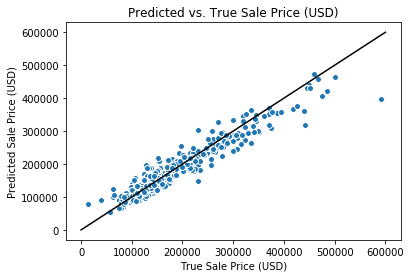

In [167]:
#Plotting Predicted SalePrice vs. True SalePrice
plt.scatter(x = y_test, y = pred_reversed_ridge_checking, edgecolors = 'w')
plt.xlabel('True Sale Price (USD)')
plt.ylabel('Predicted Sale Price (USD)')
plt.title('Predicted vs. True Sale Price (USD)')

#Plotting a line showing what a perfect fit would look like (predicted SalePrice = true SamePrice)
plt.plot( np.linspace(0,600_000,100), 
          np.linspace(0,600_000,100), 
          color = 'k')

#Source: General Assembly lesson by Matt Brems (DC), Marc Harper (LA): http://localhost:8888/notebooks/
#Desktop/DSI-US-7/Lessons/3.01-lesson-linear_regression/starter-code.ipynb

In [168]:
coeffs = ridge.coef_

In [169]:
df_coeffs = pd.DataFrame()

In [170]:
df_coeffs

""


In [171]:
df_coeffs['Features'] = np.array(features_corr_over_pt4_intns) 
df_coeffs['Beta Coefficients'] = ridge.coef_.T

In [172]:
df_coeffs.sort_values(by = 'Beta Coefficients', ascending = False)

,Features,Beta Coefficients
0,Overall Qual,0.268590
7,Gr Liv Area,0.255023
15,Exter Qual_Gd,0.207971
16,Exter Qual_TA,0.205559
4,BsmtFin SF 1,0.129366
1,Year Built,0.112555
9,Fireplaces,0.107744
6,1st Flr SF,0.103072
2,Year Remod/Add,0.097451
14,Exter Qual_Ex,0.091224


<BarContainer object of 28 artists>

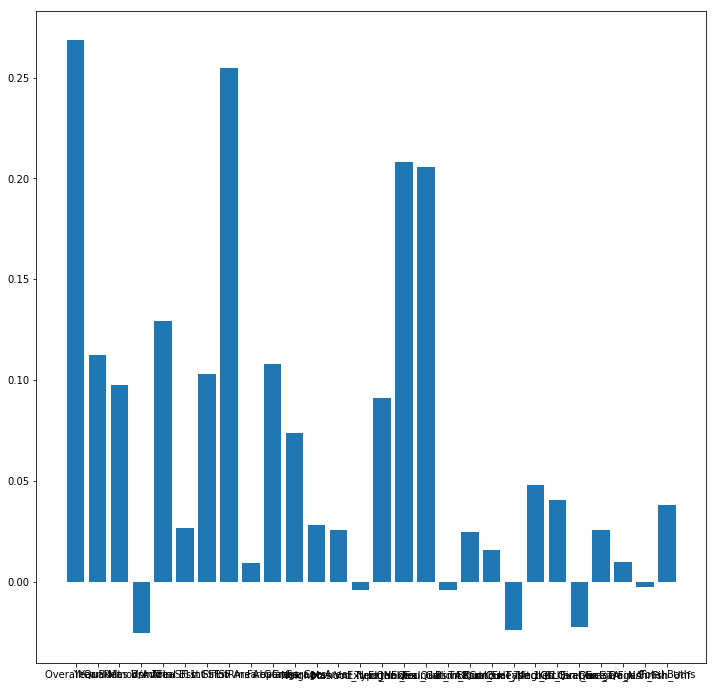

In [173]:
plt.figure(figsize = (12,12))
plt.bar(df_coeffs['Features'] , df_coeffs['Beta Coefficients'])

In [174]:
#Next, do visualizations to select Model 6 or 8
#Maybe look at RMSE, etc. for both models and make dataframe with both models' scores, etc. summarized
#Then look at coefficients to determine which features appear to have most weight in SalePrice determination
#also use the heatmap to visualize this

In [175]:
ridge.coef_.T.shape

(28, 1)

In [176]:
len(features_corr_over_pt4_intns)

28

In [177]:
features_corr_over_pt4_intns.append('SalePrice')

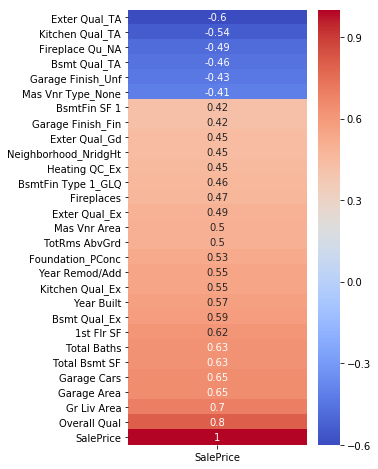

In [178]:
plt.figure(figsize = (4,8))
sns.heatmap(train_df_dum[features_corr_over_pt4_intns].corr()[['SalePrice']].sort_values('SalePrice'), 
            annot=True, cmap='coolwarm')

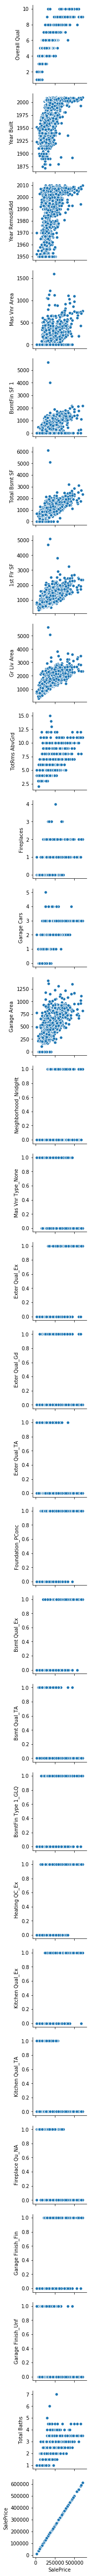

In [179]:
sns.pairplot(train_df_dum, x_vars = 'SalePrice', y_vars = features_corr_over_pt4_intns)

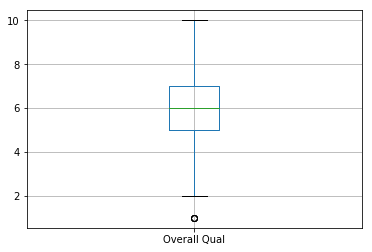

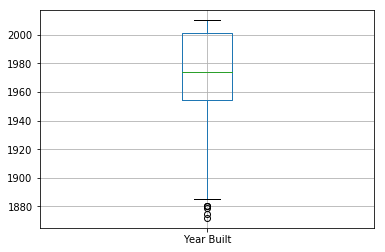

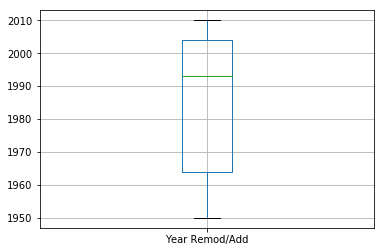

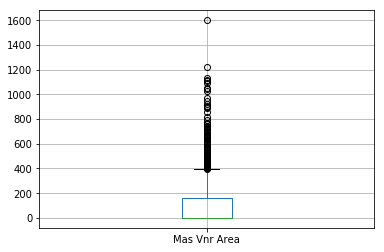

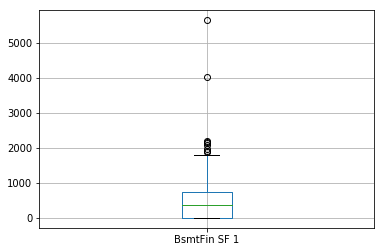

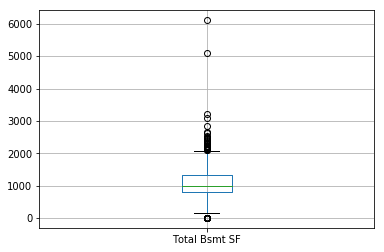

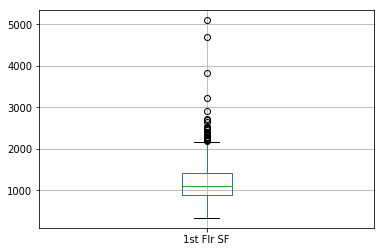

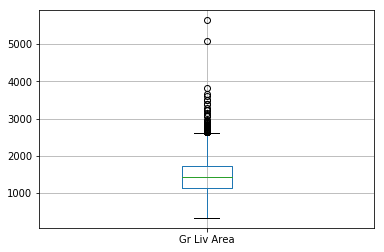

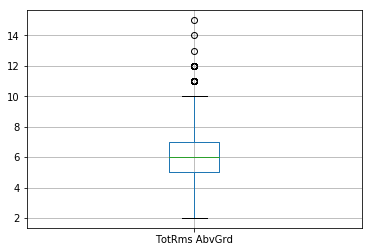

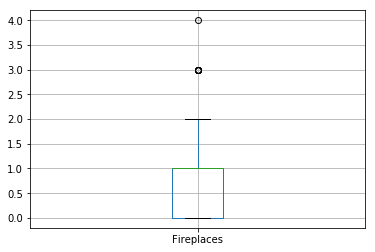

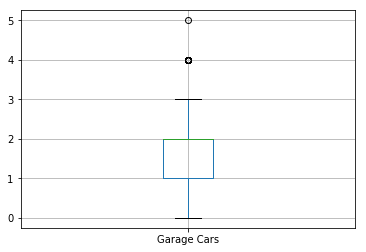

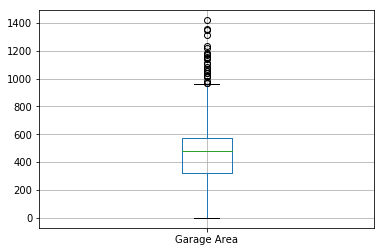

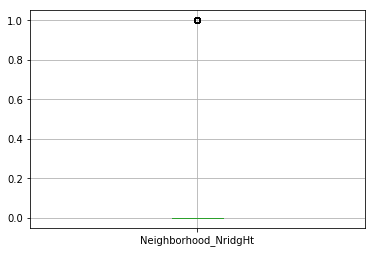

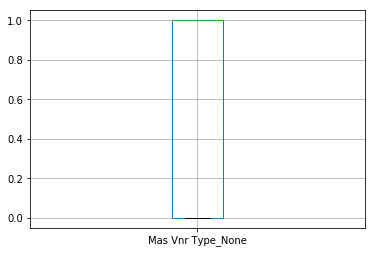

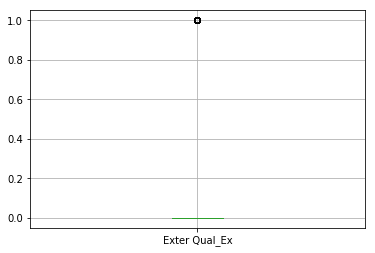

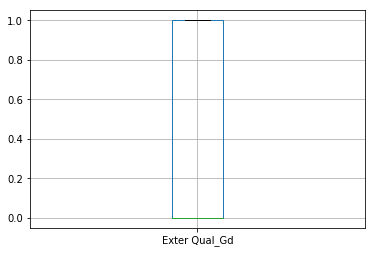

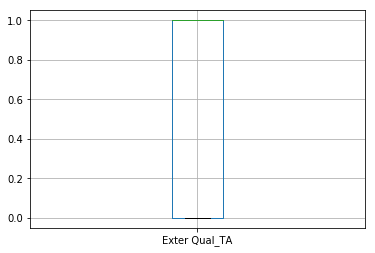

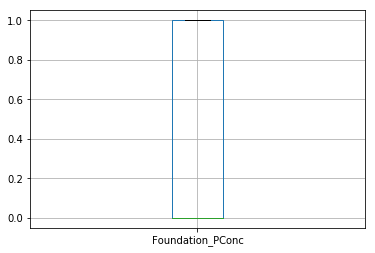

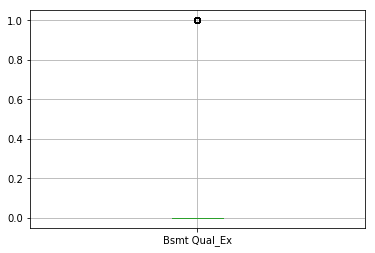

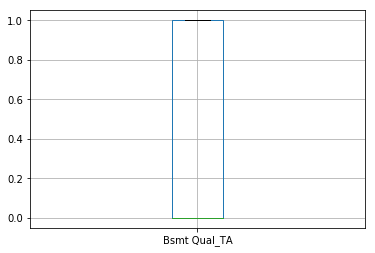

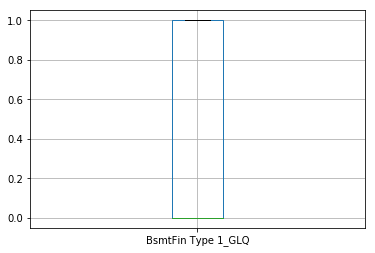

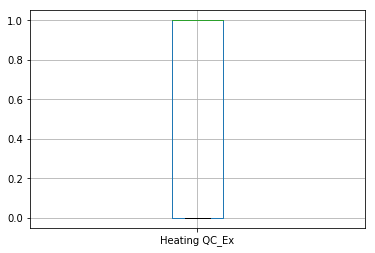

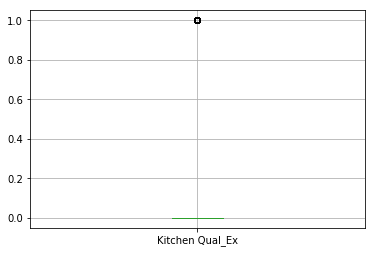

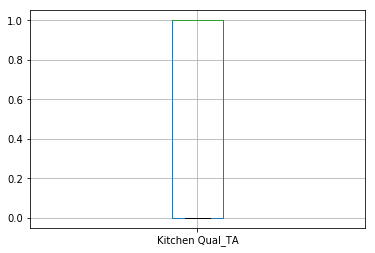

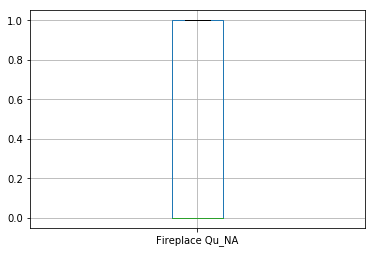

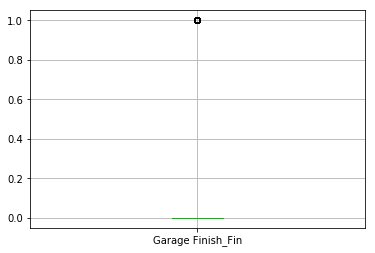

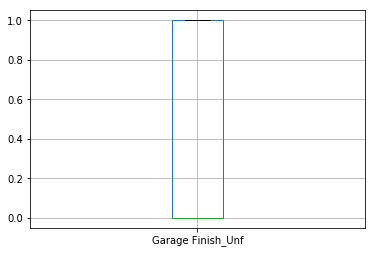

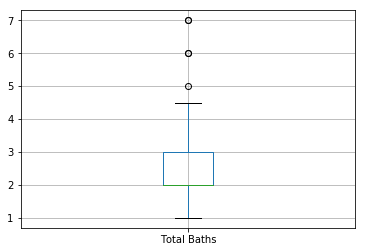

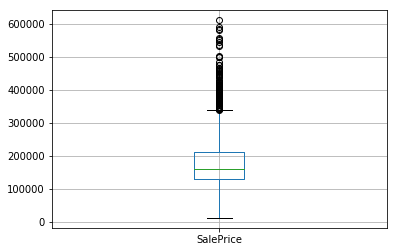

In [180]:
for i in range(len(features_corr_over_pt4_intns)):
    train_df_dum[features_corr_over_pt4_intns[i:(i+1)]].boxplot()
    plt.show()

In [181]:
#train_df_dum['Total Baths']

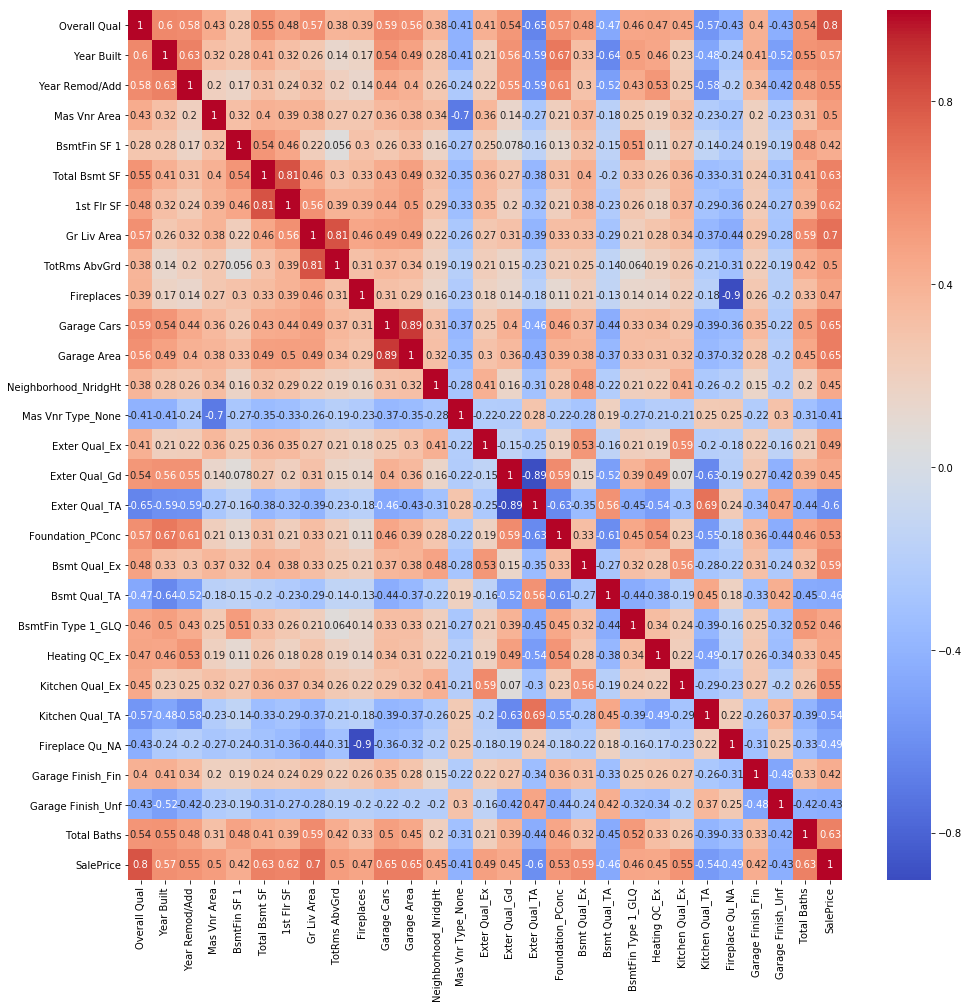

In [182]:
plt.figure(figsize = (16,16))
sns.heatmap(train_df_dum[features_corr_over_pt4_intns].corr(), annot=True, cmap='coolwarm')

It looks like there might be some collinearity of features that can be investigated to improve the model.